#**Cars 4 You: Expediting Car Evaluations with ML**

## Abstract
We executed a pipeline for predicting the price used cars for Cars4You. After performing EDA as preliminary measures of checking the presence of missing values, outliers, category noise and inconsistent values, we proceed with determinstic feature engineering (e.g., car_age, mileage_per_year) and normalisation of categories for Brand and fuelType/transmission. For the high-cardinality fields (Brand, model) frequency encoding is applied while fuelType / transmission are one-hot encoded and then dummies' validation/test are aligned to train. All trained objects (mappings, imputation, encoders, scalers, selectors) fit inside each CV fold and then they apply to validation/test. Linear regressors along with tree-based ones are compared with 5-fold CV that leads to MAE (primary), RMSE and R² reporting. When it comes to validating the MAE value, Gradient Boosting (without scalers, loss=‘absolute_error’) becomes the primary option, thus outperforming linear baselines; feature stability is analysed alongside future steps (hyperparameter tuning and optional log-target training), but no final conclusion has been reached yet.


<a id="1.1"></a>
    
# **Metadata <font>**

| **Attribute**      | **Description** |
|--------------------|-----------------|
| `carID`            | An attribute that contains an identifier for each car. |
| `Brand`            | The car’s main brand (e.g., Ford, Toyota). |
| `model`            | The car model. |
| `year`             | The year of registration of the car. |
| `mileage`          | The total reported distance travelled by the car (in miles). |
| `tax`              | The amount of road tax (in £) that, in 2020, was applicable to the car in question. |
| `fuelType`         | Type of fuel used by the car (Diesel, Petrol, Hybrid, Electric). |
| `mpg`              | Average Miles per Gallon. |
| `engineSize`       | Size of engine in liters (cubic decimeters). |
| `paintQuality%`    | Mechanic’s assessment of overall paint quality and hull integrity (filled during evaluation). |
| `previousOwners`   | Number of previous registered owners of the vehicle. |
| `hasDamage`        | Boolean marker filled by the seller at registration stating whether the car is damaged or not. |
| `price` *(train only)* | The car’s price when purchased by Cars 4 You (in £). |

<a id="1.1"></a>
    
# **1. Importing the datasets and libraries <font>**

This section, as mentioned in the title, is intended for importing the data and necessary libraries.

In [4]:
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# fuzzy matching for category correction
from thefuzz import process, fuzz

# set up of cross validation functions
from sklearn.base import clone
from collections import Counter

# model selection
from sklearn.model_selection import KFold

# scaling
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# models to try
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# to export the model and 8. Feature Importance
import joblib

import shap

# Make the project root importable so that we can do `from src...`
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loading import load_raw_data
from src.modeling import run_model, evaluate_model, avg_scores, predict_on_test



In [5]:
train_data, test_data = load_raw_data()

<a id="1"></a>

# **2. EDA & Data cleaning <font>**

In [3]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


None

The dataset has 75973 rows (cars).

In [4]:
train_data.shape

(75973, 14)

In [5]:
display(train_data.head())

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [6]:
train_data.tail(10)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
75963,67221,VW,T-Roc,2020.0,25785,Semi-Auto,10.0,Petrol,145.0,39.80000,1.5,65.0,4.0,0.0
75964,41090,Mercedes,GLC Class,2016.0,24486,NaN,22955.0,Diesel,125.0,56.50000,2.1,72.0,4.0,0.0
75965,16023,Ford,EcoSport,2017.0,10498,Manual,13613.0,Petrol,125.0,88.32164,1.0,57.0,3.0,0.0
75966,60263,Opel,Crossland X,2018.0,13995,Manual,1800.0,Petrol,150.0,57.70000,1.2,69.0,0.0,0.0
75967,44131,Mercedes,GLC Class,2018.0,30495,Semi-Auto,11943.0,Diesel,150.0,56.50000,2.1,74.0,NaN,0.0
75968,37194,Mercedes,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.30000,2.0,78.0,0.0,0.0
75969,6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.90000,2.0,38.0,2.0,0.0
75970,54886,Toyota,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.00000,1.0,57.0,3.0,0.0
75971,860,Audi,Q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.10000,2.0,74.0,2.0,0.0
75972,15795,Ford,Fiesta,2018.0,10495,Manual,16709.0,Petro,145.0,64.20000,1.1,38.0,1.0,0.0


<a id="1"></a>

## **2.1. Descriptive statistics <font>**

Computing the descriptive statistics for the numerical variables.

* For the year column the maximun value is 2024.1217; we should correct it to an integer with no decimal part.
* The paint quality % has values exceeding 100%.

In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75973.0,37986.000000,21931.660338,0.000000,18993.00,37986.0,56979.0,75972.000000
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,74449.0,64.590667,21.021065,1.638913,47.00,65.0,82.0,125.594308
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


In [8]:
train_data.describe(include='O').T

,count,unique,top,freq
Brand,74452,72,Ford,14808
model,74456,735,Focus,6353
transmission,74451,40,Manual,38050
fuelType,74462,34,Petrol,37995


We suspect that the variable '`hasDamage`' only has the value 0.0.

In [9]:
train_data['hasDamage'].value_counts()

hasDamage
0.0    74425
Name: count, dtype: int64

## 2.2. Data cleaning

We need to create a copy before we perform any operation, to preserve the original version. It is important to note that the preprocessing we are applying here, to remove the inconsistencies, is being applied to both train and test data. We are only applying deterministic changes at this point, to prevent data leakage.

In [10]:
train = train_data.copy()
test = test_data.copy()

Regarding variables that should be excluded from the dataset:
* `hasDamage` only takes the value 0.0 in the train/validation data; it has no relevant information to predict price, therefore it will be removed;
* `paintQuality%` should also be removed, because results from the mechanic's assessment of the overall paint quality. Our model is meant to do predictions based on the user's input, without going to the mechanic.

In [11]:
train = train.drop(columns=['hasDamage'], axis = 1)
train = train.drop(columns=['paintQuality%'], axis = 1)
test = test.drop(columns=['hasDamage'], axis=1)
test = test.drop(columns=['paintQuality%'], axis=1)

### 2.1.1. Numerical inconsistencies

**Inconsistencies**

The following list summarizes the inconsisties we searched for and identified, involving the numerical features:
*  **Engine size set to zero** when the car is **not eletric** (note that, even though the categories for `fuelType` are all misspelled, the electric one is the only intact, so we can filter it in this way): assuming these are note real zeros, **set them to Nan** to impute later seems the best approach.
* **Non zero miles per gallon for eletric cars**: in these cases, we will **set mpg to zero**.
* Cars with over 200 miles per gallon: after some research on the regular/usual values for consumption in miles per gallon, we consider all values higher than 200 mpg an error that needs to be corrected. 200 miles per gallon is extremely high for almost any regular car. Therefore we will convert them to **Nan** to later be imputed.
* **Year as a float**: We are going to correct this by **rounding to the closest integer**.
* Years after 2020:  cars 4 you has provided this data from an older version of the database, from 2020. Therefore, all values after 2020 don't make sense. We assume this was an error and in reality these cars are older than that: we will set them to **Nan** and impute them later.
* negative values in `mileage`, `tax`, `mpg`, `engineSize`, `previousOwners`: this must be an error in data collection, therefore will be replaced by **Nan**.

In [12]:
train[(train['engineSize']==0)& (train['fuelType'] != "Electric")]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners
64,30317,Ford,NaN,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,3.0
759,21935,Ford,KA,2018.0,8444,Manual,17000.0,Petrol,145.0,57.7,0.0,0.0
1039,9518,BMW,2 Series,2015.0,14700,Automatic,32882.0,Diesel,125.0,60.1,0.0,0.0
1057,32528,Hyundai,Tucson,2016.0,13800,Manual,27311.0,Diesel,30.0,61.7,0.0,1.0
1519,33804,Hyundai,Tucson,2019.0,15000,Manual,22397.0,Petrol,150.0,34.9,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74469,26630,Ford,Fiesta,2018.0,11463,NaN,18000.0,Petro,145.0,65.7,0.0,0.0
75168,20128,Ford,Focus,2018.0,18389,Manual,19000.0,Petrol,NaN,NaN,0.0,2.0
75401,47605,Skoda,Fabia,2018.0,11500,Manual,10720.0,Petrol,150.0,64.2,0.0,4.0
75405,33307,Hyundai,I10,2018.0,8500,Manual,12948.0,Petrol,145.0,60.1,0.0,2.0


In [13]:
train.loc[(train['engineSize']==0)& (train['fuelType'] != "Electric"), "engineSize"] = np.nan
test.loc[(test['engineSize']==0)& (test['fuelType'] != "Electric"), "engineSize"] = np.nan

In [14]:
train[(train['mpg'] != 0) & (train['fuelType'] == "Electric")]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners
6978,12786,NaN,i3,2015.0,17400,Automatic,29465.0,Electric,0.0,470.8,3.822758,2.0
37023,64169,Opel,Ampera,2015.0,12999,Automatic,34461.0,Electric,0.0,235.4,1.400000,1.0
52274,21931,Ford,Mondeo,NaN,15500,Automatic,24531.0,Electric,0.0,67.3,2.000000,4.0
52579,16306,Ford,Mondeo,2016.0,15975,automatic,9396.0,Electric,0.0,67.3,2.000000,3.0


In [15]:
train.loc[(train['mpg'] != 0) & (train['fuelType'] == "Electric"), 'mpg'] = 0
test.loc[(test['mpg'] != 0)& (test['fuelType'] == "Electric"), 'mpg'] = 0

In [16]:
train[(train['mpg'] > 200)]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners
552,53577,Toyota,PRIUS,2018.0,19072,Automatic,43584.000000,Hybrid,135.0,235.0,2.781776,1.00000
4101,13075,BMW,i3,2015.0,15498,Automatic,33931.000000,Hybrid,0.0,470.8,NaN,4.00000
4191,31699,Hyundai,Ioniq,2018.0,18970,Automatic,14886.000000,Hybrid,135.0,256.8,1.600000,4.00000
4935,44875,Mercedes,C Class,2020.0,40999,Automatic,400.000000,Other,135.0,217.3,2.000000,0.00000
5278,12640,BMW,i3,2017.0,19500,Automatic,23956.000000,Other,135.0,470.8,0.600000,1.00000
7904,55563,Toyota,Prius,2019.0,28590,Automati,5000.000000,Other,135.0,217.3,1.800000,0.00000
10158,48968,Skoda,Superb,2020.0,29995,Semi-Auto,15.000000,Hybrid,140.0,201.8,1.400000,0.00000
17247,50564,Skoda,Superb,2020.0,28332,Semi-Auto,5000.000000,Hybrid,135.0,201.8,1.400000,0.00000
17955,53572,Toyota,Prius,2018.0,22890,Automatic,31786.000000,Hybrid,135.0,235.0,1.800000,1.00000
18261,8993,BM,i3,2016.0,18999,Automatic,9990.000000,NaN,0.0,470.8,NaN,0.00000


In [17]:
train.loc[train['mpg'] > 200, 'mpg'] = np.nan
test.loc[train['mpg'] > 200, 'mpg'] = np.nan

In [18]:
# Round the 'year' column to the nearest integer and convert to integer type
train['year'] = train['year'].round().astype('Int64')
test['year'] = test['year'].round().astype('Int64')

In [19]:
train[train['year']>2020]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners
35,53282,Toyota,Yaris,2023,16995,Manual,1225.0,Petrol,145.0,47.9,1.5,0.0
216,20770,Ford,Kuga,2023,16950,Manual,3376.0,Diesel,145.0,54.3,1.5,1.0
590,42947,mercedes,GLE Class,2024,54885,Automatic,10516.0,Diesel,145.0,NaN,3.0,4.0
647,22446,Ford,fiesta,2023,10700,manual,8015.0,Petrol,145.0,55.4,1.1,1.0
859,11832,BMW,Z4,2024,31350,Automatic,111.0,Petrol,145.0,38.7,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
73935,22614,Ford,KUGA,2023,13998,MANUAL,32544.0,Diesel,145.0,54.3,2.0,2.0
74468,75005,VW,Touran,2023,14995,unknown,23746.0,Diesel,30.0,65.7,1.6,0.0
74591,44569,Mercedes,C Class,2024,22532,Semi-Auto,20150.0,Petro,NaN,NaN,2.0,3.0
74900,57384,Opel,Mokka,2023,7299,Manual,56136.0,Diesel,30.0,62.8,1.7,4.0


In [20]:
train.loc[train['year'] > 2020, 'year'] = np.nan
test.loc[test['year'] > 2020, 'year'] = np.nan

In [21]:
train[(train["mileage"]< 0) | (train["tax"]< 0) |
           (train["mpg"]< 0) | (train["engineSize"]< 0) |
           (train["previousOwners"]< 0)]

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,previousOwners
3,29021,Ford,FIESTA,2018,12500,anual,9102.000000,Petrol,145.000000,65.7,1.0,-2.340306
26,35263,Mercedes,C Clas,<NA>,11295,Automatic,45000.000000,Petrol,-56.193202,46.3,1.6,NaN
126,71677,VW,Tiguan,2019,29999,Semi-Auto,669.000000,Diesel,145.000000,39.8,2.0,-2.345650
168,46204,Mercedes,C Class,2019,66699,Semi-Auto,630.000000,Petrol,-56.193202,28.5,4.0,2.000000
268,70615,VW,Tiguan,2020,25000,Manual,-48190.655673,Petrol,145.000000,38.2,1.5,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
75791,15708,Ford,Focu,2019,16998,Automatic,8703.000000,Petrol,-45.780610,40.9,1.5,0.000000
75859,55820,oyota,Aygo,2019,8491,Manual,-39765.602338,Petrol,145.000000,56.5,1.0,0.000000
75883,52251,Toyota,Hilux,2018,22498,Manual,-39765.602338,NaN,265.000000,40.4,2.4,3.000000
75912,55591,Toyota,Aygo,2019,8480,Manual,5976.000000,Petrol,145.000000,56.5,1.0,-2.340102


In [22]:
columns_to_check = ["mileage", "tax", "mpg", "engineSize", "previousOwners"]

for col in columns_to_check:
    train.loc[train[col] < 0, col] = np.nan
    test.loc[test[col] < 0, col] = np.nan

### 2.1.2. Categorical inconsistencies

**Inconsistencies**:

It is important to take a closer look at the weird amount of unique values for `transmission`, `Fuel type`, `Brand` and `model`. There are model names such as "pol" that should be named "polo" from Volkswagen, for example.

In [23]:
# Display unique values for 'transmission'
print("Unique values for Transmission:")
print(train['transmission'].unique())

# Display unique values for 'fuelType'
print("\nUnique values for Fuel Type:")
print(train['fuelType'].unique())

# Display unique values for 'Brand'
print("\nUnique values for Brand:")
print(train['Brand'].unique())

# Display unique values for 'Model'
print("\nUnique values for Model:")
print(train['model'].unique())

Unique values for Transmission:
['Semi-Auto' 'Manual' 'anual' 'Semi-Aut' 'Automatic' 'manual' nan
 'unknown' 'Manua' 'AUTOMATIC' 'MANUAL' 'semi-auto' ' Manual ' 'automatic'
 'emi-Auto' 'SEMI-AUTO' 'SEMI-AUT' 'Automati' 'ANUAL' 'utomatic' 'unknow'
 'EMI-AUTO' 'manua' 'anua' 'emi-Aut' 'MANUA' 'emi-auto' 'UTOMATIC'
 ' manual ' ' MANUAL ' 'UNKNOWN' 'nknown' 'automati' 'Other' 'semi-aut'
 ' Manual' 'AUTOMATI' 'utomati' 'Manual ' 'manual ' 'nknow']

Unique values for Fuel Type:
['Petrol' 'Diesel' 'etrol' 'Hybrid' 'diesel' 'iesel' nan 'petrol' 'PETROL'
 'Diese' 'Petro' 'DIESEL' 'petro' 'HYBRID' 'ybri' 'Other' 'DIESE' 'Hybri'
 'ETROL' 'ybrid' 'PETRO' 'hybrid' 'IESEL' 'Electric' 'ther' 'iese' 'etro'
 'ETRO' 'diese' 'Othe' 'YBRID' 'HYBRI' 'OTHER' 'other' 'IESE']

Unique values for Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'

We should find a clever way to solve these inconsistencies. Taking `model` as an example, with more than 700 unique values (most of them uncorrect one), we need a robust and efficient strategy to correct the categories.

A deeper visual inspection reveals that some issues stem from sensitivity (lowercase vs uppercase) and minor variations such as *"series"* vs *"serie"* (in the case of model),  which can be solved deterministically. In many of the cases, the last letter was cut off, thus corrections should complete the words.

On the other hand, in some variables we see more complex typos like brands missing many letters, shuffling of letters or using abreviations, which require a smarter strategy than only normalizing and adding 's's and '-'. We decided to apply fuzzy matching, so we could convert all forms of writting a brand into only one, through similarity (more on this later).

In [24]:
def norm_text(s: pd.Series) -> pd.Series:

  ''' Function to normalize model categories:
  - manages differring representations of characters
  - removes the spaces before and after
  - converts to lowercase
  - convert multiple spaces to one'''

  return (s.astype('string')
             .str.normalize('NFKC') # to manage different representations of certain characters
             .str.strip() # remove spaces before and after
             .str.lower() # convert everything to lower case
             .str.replace(r'\s+', ' ', regex=True)) # to convert multiple spaces to only one

In [25]:
def clean_model(model: pd.Series) -> pd.Series:

  ''' Works in sync with norm_text function, that performs the initial normalization.
   After ensuring the values are all written within the same patters (norm_text function),
   we have to correct the lack of 's' in the end of some words, and the usage of '-' within the
   names of some models. We also included specific corrections for some models. Aditionally, we ensure only a-z,
   0-9 and +- are allowed, and replace empty categories (withe spaces) by Nan'''

  m = norm_text(model)

    # 1) Semantic normalization - transform small errors in the way of writing, so classes are uniform
  m = (m
         # BMW: serie -> series
        .str.replace(r'\bserie\b', 'series', regex=True)
         # Mercedes: clas/claaass -> class
        .str.replace(r'\bclas+\b', 'class', regex=True)
         # Unificar t-roc / t roc
        .str.replace(r'\bt\s*[- ]\s*roc\b', 't-roc', regex=True)
        .str.replace(r'\bt\s*[- ]\s*cross\b', 't-cross', regex=True)
        # Opel Combo: lif -> life
        .str.replace(r'\bcombo lif\b', 'combo life', regex=True)
        # Caddy Maxi: lif -> life
        .str.replace(r'\bcaddy maxi lif\b', 'caddy maxi life', regex=True)
        # Ford Edge: edg -> edge
        .str.replace(r'\bedg\b', 'edge', regex=True)
        # many other imcomplete models
        .str.replace(r'\bcors\b', 'corsa', regex=True)
        .str.replace(r'\bmokk\b', 'mokka', regex=True)
        .str.replace(r'\btucso\b', 'tucson', regex=True)
        .str.replace(r'\btigua\b', 'tiguan', regex=True)
        .str.replace(r'\bhilu\b', 'hilux', regex=True)
        .str.replace(r'\bvers\b', 'verso', regex=True)
        .str.replace(r'\byari\b', 'yaris', regex=True)
        .str.replace(r'\byet\b', 'yeti', regex=True)
        .str.replace(r'\btourneo custo\b', 'tourneo custom', regex=True)
        .str.replace(r'\brav\b', 'rav4', regex=True)
        .str.replace(r'\bs ma\b', 's-max', regex=True)
        .str.replace(r'\bscirocc\b', 'scirocco', regex=True)
        .str.replace(r'\btouare\b', 'touareg', regex=True)
        .str.replace(r'\bcoroll\b', 'corolla', regex=True)
        .str.replace(r'\bamaro\b', 'amarok', regex=True)
        .str.replace(r'\bcruise\b', 'cruiser', regex=True)
        .str.replace(r'\becospor\b', 'ecosport', regex=True)
        .str.replace(r'\bzafir\b', 'zafira', regex=True)
        .str.replace(r'\bkon\b', 'kona', regex=True)
        .str.replace(r'\bmeriv\b', 'meriva', regex=True)
    )


    # 2) only maintaining specific simbols: a-z; 0-9 and + -
  m = (m
         .str.replace(r'[^a-z0-9\+\- ]', ' ', regex=True)
         .str.replace(r'\s+', ' ', regex=True)
         .str.strip())

    # empty strings are set to NaN
  m = m.replace('', pd.NA)
    # extremely short junk like 'i' should be NaN as well
  m = m.mask(m.str.len() == 1, pd.NA)
  return m


In [26]:
train["model"] = clean_model(train["model"])
test["model"] = clean_model(test["model"])

**Fuzzy matching**

To solve the misspelled categories in the variables `Brand`, `transmission` and `Fuel type`, we opted for using Fuzzy matching, since correcting them by hand was a very time consuming and non-efficient method.

This is simply approximate string matching, which is based on the idea of edit diference: *"how close two strings are by finding the minimum number of “edits” required to transform one string to another"* ([Data Camp](https://www.datacamp.com/tutorial/fuzzy-string-python), Fuzzy String Matching in Pyhton).

In our case, this implementation uses The Levenshtein Distance, one of the many ways to compute edit distance.

This dictionary stores the correct and accepted categories, based on the general value counts of the variables.

In [27]:
canonical = {
    'fuelType':     ['diesel','petrol','hybrid','electric','other'],
    'transmission': ['manual','automatic', 'semi-automatic', 'other'],
    'Brand': ['audi','bmw','ford','hyundai','mercedes','opel','skoda','toyota','volkswagen']
}

This function will capture all the occurrences different than the canonical values, and suggest corrections through fuzzy matching. These pairs of (misspelled category - correction) will be stored in a dictionary that will be applied to validation and test, preventing data leakage by only learning on the train data. We created small *if statements* inside the function to provide extra support in categories with less than 3 letters, where the prediction scores were very low, and thus the suggestions were weak.

This strategy can be applied to `transmission`, `fuelType` and `Brand`, using different functions for each.

In [28]:
def learn_brand_map(series, canon=canonical["Brand"], threshold=80):

  ''' Takes a series of brand names and stores all the unique occurences of Brand categories differing
  from the canonical ones and a suggested correction through fuzzy matching. For very short values, with
  less than 3 letters, there's hard coded corrections. The treshold, with defualt value of 80,
  ensures we only use corrections of fuzzy where we have a score ('resemblence' wiht a canonical
  value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''
  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      if len(u) <= 2:   # avoid “vw”→“bmw”, these are examples fuzzy might predict wrongfully
          if u == "vw" or u=="v":
            mapping[u] = "volkswagen"
          elif u== "op" or u=="pe":
            mapping[u] = "opel"
          elif u== 'bm' or u=='w' or u=='mw':
            mapping[u] = "bmw"
          elif u== 'au' or u=='a' or u=='di' or u=='ud':
            mapping[u] = "audi"
          elif u=='fo' or u=='or':
            mapping[u] = "ford"

          if u in mapping:
            continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m

  return mapping

In [29]:
def learn_transmission_map(series, canon=canonical["transmission"], threshold=80):

  ''' Takes a series of transmission types and stores all the unique occurences of these transmission
  categories differing from the canonical ones and a suggested correction through fuzzy matching. Unknown
  values (where its actually typed unknown) are set to Nan. The treshold, with defualt value of 80,
  ensures we only use corrections of fuzzy where we have a score ('resemblence' wiht a canonical
  value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''

  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      if u == 'unknown' or u == 'unknow' or u == 'nknow' or u == 'nknown':
        mapping[u] = np.nan
      if u in mapping:
        continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m
  return mapping

In [30]:
def learn_fuel_map(series, canon=canonical["fuelType"], threshold=80):

  ''' Takes a series of fuel types and stores all the unique occurences of these fuel
  categories differing from the canonical ones and a suggested correction through fuzzy matching.
  The treshold, with defualt value of 80, ensures we only use corrections of fuzzy where we have a
  score ('resemblence' wiht a canonical value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''

  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      # tratar tokens que são claramente "missing"
      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m
  return mapping

This complementary function applies the mapping to the columns. Therefore, it will be used to apply the mapping to train, validation and test data.

In [31]:
def apply_brand_map(series, mapping):

  '''Paired with lear_brand_map function, this one applies the mapping to correct the brand categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

  s = (series.astype(str).str.lower().str.strip())
  return s.replace(mapping)

In [32]:
def apply_transmission_map(series, mapping):

  '''Paired with lear_transmission_map function, it applies the mapping to correct the transmission categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

  s = (series.astype(str).str.lower().str.strip())
  return s.replace(mapping)

In [33]:
def apply_fuel_map(series, mapping):

    '''Paired with lear_fuel_map function, it applies the mapping to correct the fuel type categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

    s = (series.astype(str).str.lower().str.strip())
    return s.replace(mapping)

As this step is equivalent to lowercasing, stripping spaces, or applying a hand-crafted dictionary of corrections, we can apply it before splitting the data into training and validation. Running these functions once on the full training data (and then applying the same mapping to the test set) does not introduce data leakage and simplifies the pipeline

In [34]:
# Learn mapping only on train (train_validation, since we haven't splitted the data yet)
brand_map = learn_brand_map(train['Brand'])
fuel_map  = learn_fuel_map(train['fuelType'])
trans_map = learn_transmission_map(train['transmission'])

# Apply the same mapping to train and test
train['Brand'] = apply_brand_map(train['Brand'], brand_map)
test['Brand'] = apply_brand_map(test['Brand'],  brand_map)

train['fuelType'] = apply_fuel_map(train['fuelType'], fuel_map)
test['fuelType'] = apply_fuel_map(test['fuelType'],  fuel_map)

train['transmission'] = apply_transmission_map(train['transmission'], trans_map)
test['transmission'] = apply_transmission_map(test['transmission'],  trans_map)


### 2.1.3. Duplicates

In [35]:
train.duplicated().sum()

np.int64(0)

In general, there's no rows where all values are the same, and there's no repeated instances for `carID`.

In [36]:
train.duplicated(subset=['carID']).sum()

np.int64(0)

### 2.1.4. Missing Values

After solving the inconsistencies by introducing Nan it is important to analyse the percentage of missing values per features. We have no columns with more than 50% of missing data, therefore we don't have any concerns regarding excess of missing data in the current features.
Regarding strategies to further impute these missing values, we intend to:
* for the numerical features, impute missing values with the **median** (as shown further, the distributions are skewed, thus the mean is not as robust as the median).
* for the categorical ones, impute with the **mode**.

In [37]:
# Check for the % of missing values
train.isna().sum() /len(train) * 100

carID              0.000000
Brand              2.002027
model              2.262646
year               2.433759
price              0.000000
transmission       2.972109
mileage            2.411383
fuelType           1.988864
tax               10.901241
mpg               10.545852
engineSize         2.342938
previousOwners     2.528530
dtype: float64

Additionally it is important to assess the amount of missing values per row. Rows with a high percentage of missing data will require imputations in many columns, making them almost artificial. However, it seems there's no rows with this problem.

In [38]:
# Calculate the percentage of missing values per row
missing_percentage_per_row = train.isnull().sum(axis=1) / len(train.columns) * 100

# Count rows with 50% or more missing values
rows_with_50_percent_missing = (missing_percentage_per_row >= 50).sum()

print("Percentage of missing values per row:")
display(missing_percentage_per_row)

print(f"\nNumber of rows with 50% or more missing values: {rows_with_50_percent_missing}")

Percentage of missing values per row:


0        8.333333
1        0.000000
2        0.000000
3        8.333333
4        0.000000
           ...   
75968    0.000000
75969    0.000000
75970    0.000000
75971    0.000000
75972    0.000000
Length: 75973, dtype: float64


Number of rows with 50% or more missing values: 0


<a id="1"></a>

## **2.2. Data visualization <font>**

### 2.2.1 Univariate exploratiom

Boxplots and histograms were used to assess the distributions of the variables and the presence of outliers.

We have outliers in the following variables:
* `year`: has long tail to the left, containing somo statistical outliers - a few cars in 1970;
* `mileage`: has a skewed distribution and some outliers to the right; there's cars with 300,000 of mileage;
* `tax`: presents both very high (>500) and very low values (<50) for the road tax amount in 2020.
* `mpg`: has a skewed distibution with outliers;
* `engineSize`: has a skewed distribution with some possible outiliers to the right
* `previousOwners`: also presents a centered distribution but with some extreme values (>6 previous owners)
* `price`: showcases a long tail to the right (skewed distribution)

This suggests that, in some variables a log transformation might be useful to help aproximate its distribution to a normal one (Explored more deeply in other visualizations).


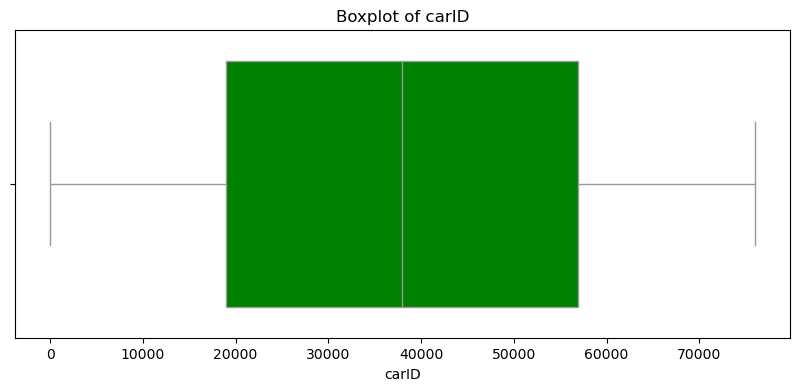

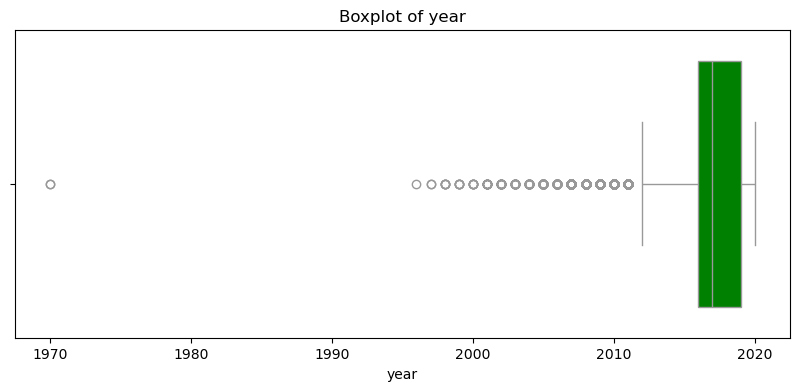

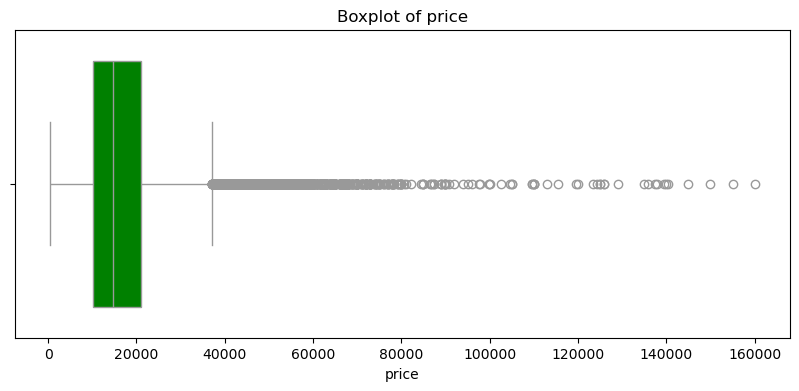

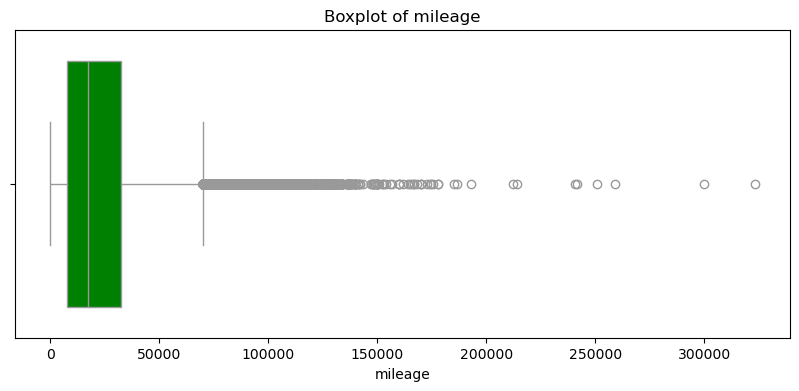

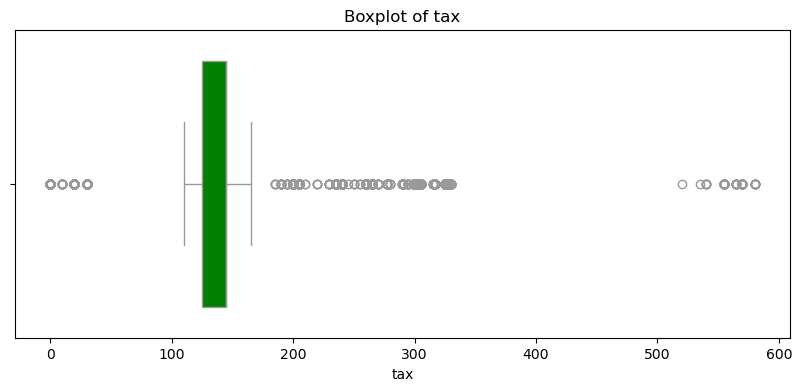

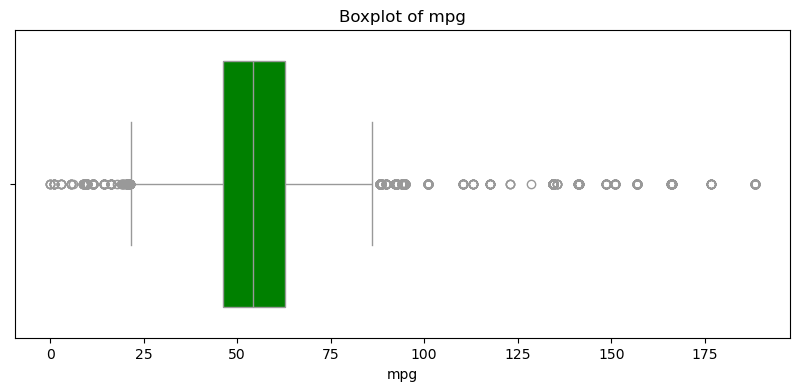

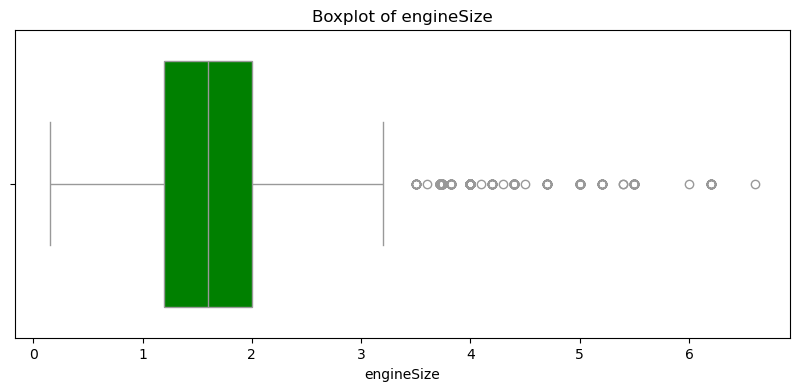

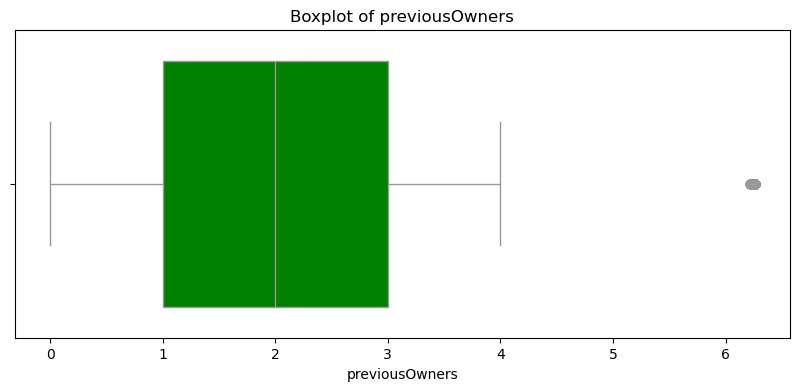

In [39]:
# Boxplots to check for outliers
for column in train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train[column], color='white', boxprops=dict(facecolor='green'))
    plt.title(f'Boxplot of {column}')
    plt.show()

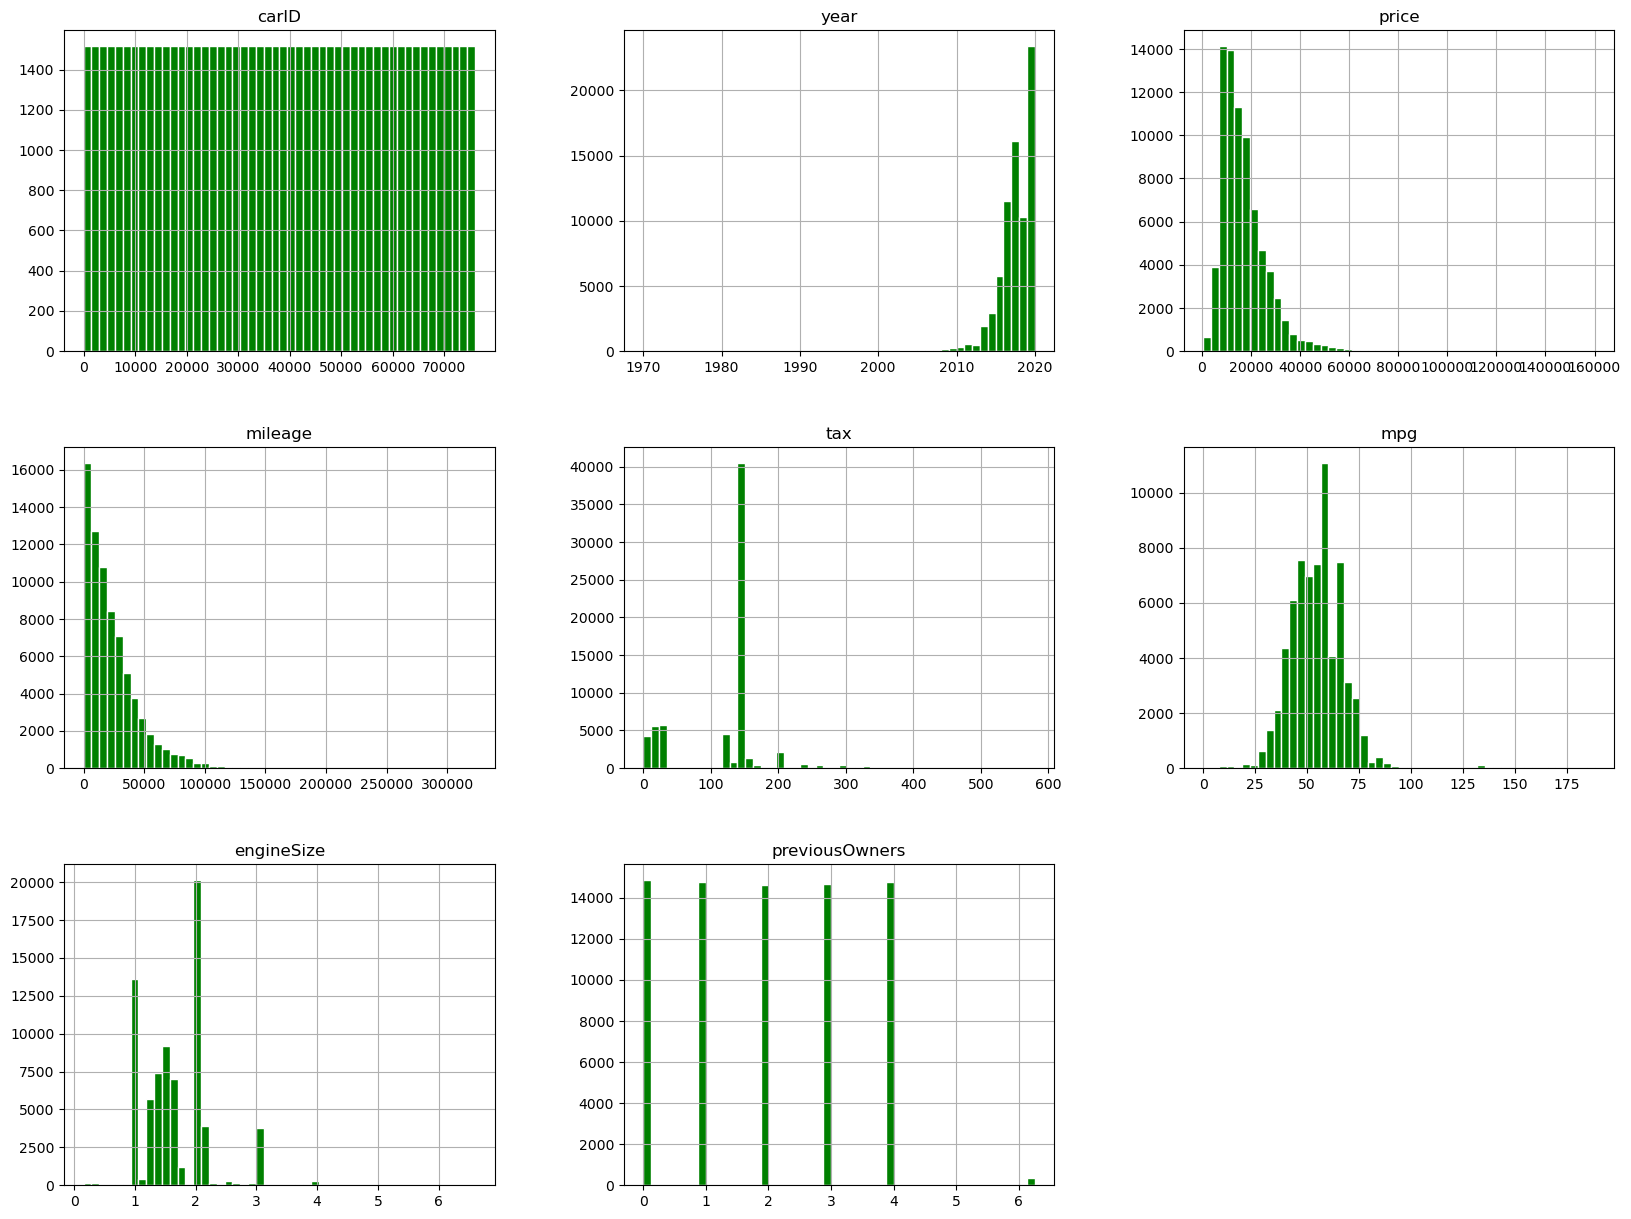

In [40]:
# Histograms for each numerical attribute
train.hist(bins=50, figsize=(20,15), color='green', edgecolor='white')
plt.show()

We performed some distribution checks and log-scale exploration for key variables to consider preprocessing choices:

 - `mileage`: long right tail, being a proxy for usage.
 - `tax`: showcases discrete bands with a long tail.
 - `mpg`: moderately skewed.
 - `engineSize`: slightly skewed.
 - `price` : very skewed (long tail to the right)


If log1p visibly reduces skew / compresses heavy tails, we may apply the transformation later to improve linear-model assumptions (more stable variance, fewer outlier effects).
   


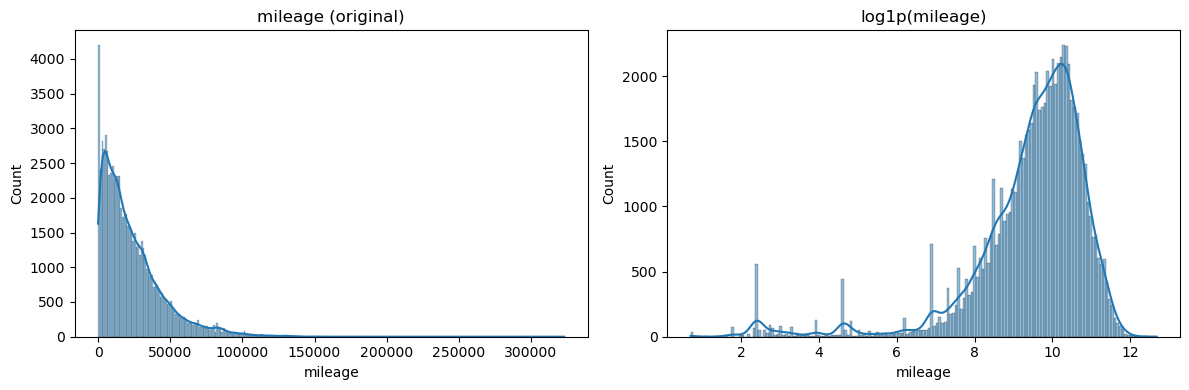

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["mileage"], kde=True, ax=axes[0])
axes[0].set_title("mileage (original)")

sns.histplot(np.log1p(train["mileage"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(mileage)")
plt.tight_layout()


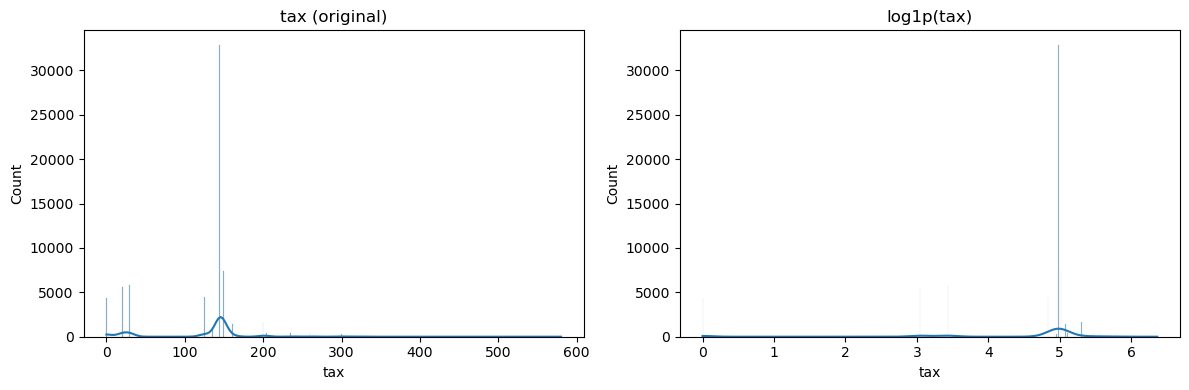

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["tax"], kde=True, ax=axes[0])
axes[0].set_title("tax (original)")

sns.histplot(np.log1p(train["tax"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(tax)")
plt.tight_layout()


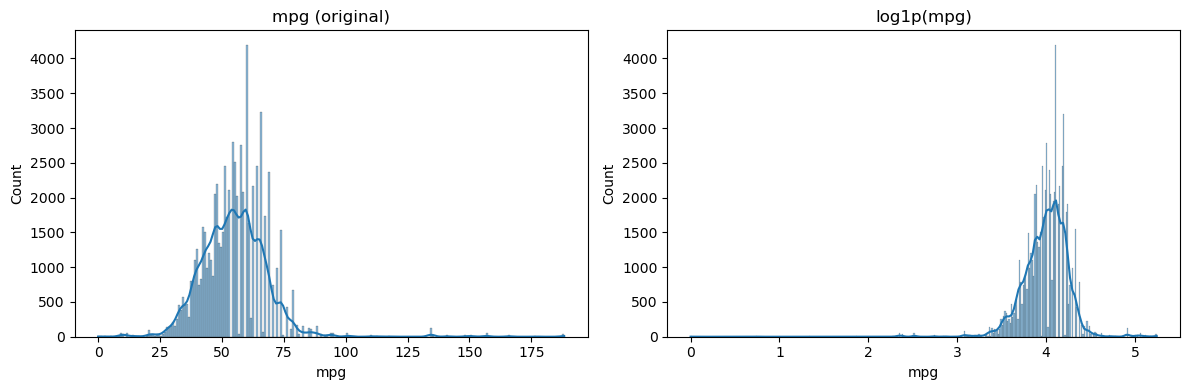

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["mpg"], kde=True, ax=axes[0])
axes[0].set_title("mpg (original)")

sns.histplot(np.log1p(train["mpg"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(mpg)")
plt.tight_layout()


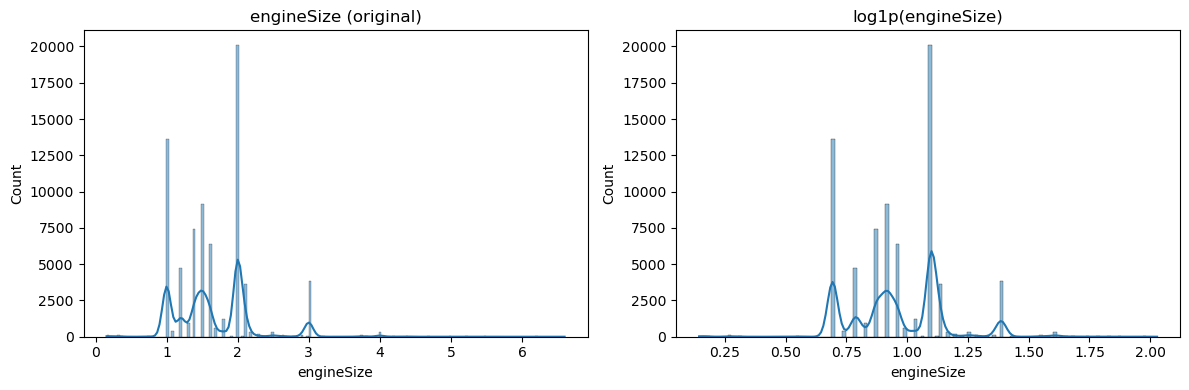

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["engineSize"], kde=True, ax=axes[0])
axes[0].set_title("engineSize (original)")

sns.histplot(np.log1p(train["engineSize"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(engineSize)")
plt.tight_layout()


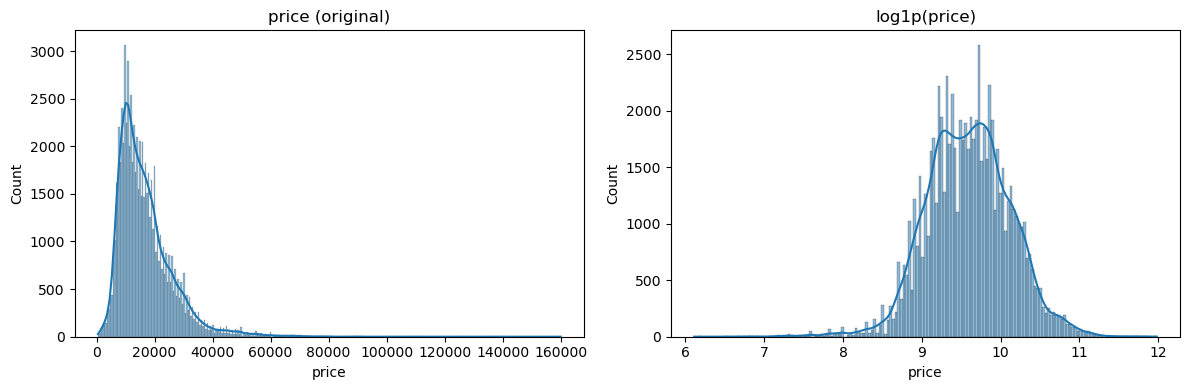

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["price"], kde=True, ax=axes[0])
axes[0].set_title("price (original)")

sns.histplot(np.log1p(train["price"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(price)")
plt.tight_layout()

**Conclusions:**
* We can try using log in `Mileage`, `engineSize` and `tax`, to help center the distributions.
* In `price`, with a tail to the right, the log truly centers the distribution, being now approximate to a normal one. So there may be advantages in using `log(price)` as well

In [46]:
brand_stats = (
    train
    .groupby('Brand')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)

display(brand_stats)

transmission_stats = (
    train
    .groupby('transmission')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)

display(transmission_stats)

fuel_stats = (
    train
    .groupby('fuelType')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)

display(fuel_stats)


,count,mean_price
Brand,,
ford,16063,12581.911909
mercedes,11674,24472.962052
volkswagen,10177,16875.436081
opel,9352,10367.619547
bmw,7600,22481.453816
audi,7325,22887.952765
toyota,4622,12480.692774
skoda,4303,14242.607251
hyundai,3336,12791.963729


,count,mean_price
transmission,,
manual,41627,12193.656809
semi-automatic,16878,24308.028854
automatic,15205,21476.664716
other,5,16936.800000


,count,mean_price
fuelType,,
petrol,41181,15019.461281
diesel,30885,19181.155869
hybrid,2225,19276.771685
other,167,17202.077844
electric,4,15468.500000


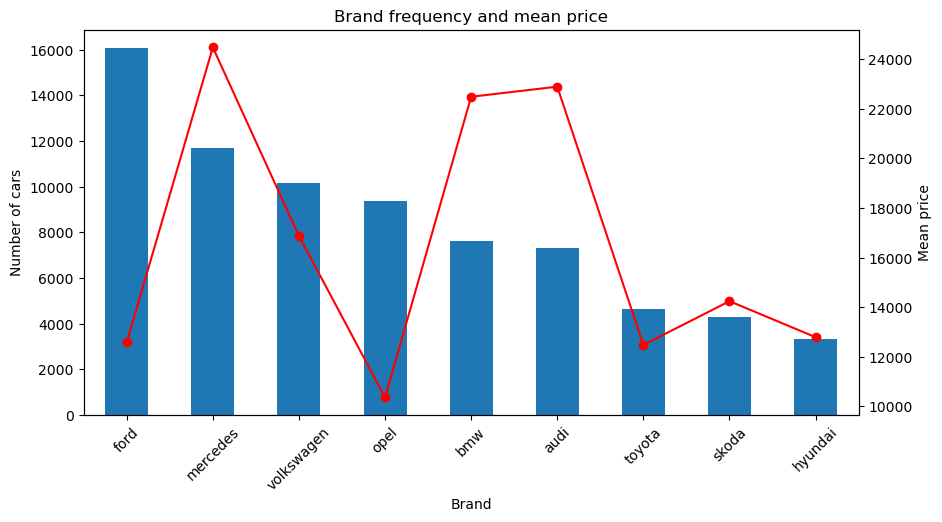

In [47]:
ax = brand_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(brand_stats.index, brand_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Brand frequency and mean price")
ax.tick_params(axis='x', rotation=45)

We can see big differences in prices for different brands, suggesting that brand is an important predictor of price, as we could expect. However, there's not a clear and observable trend between the frequency of each brand and its price. Either way, there's some notes worth taking:

 1.   we clearly have **2 clusters of prices** here: high hand, with higher prices (mercedes, bmw and audi) and medium to cost friendly cars (ford, opel, toyota, skoda, hyundai and volkswagen);

 Considering this, a new **binary variable distinguishing these 2 price groups**, could help predict prices (something to be implemented in the feature engineering stages).

2.  toyota, skoda and hyundai are **the least frequent** and display on average **lower prices**;
3.  mercedes showcases the highest average price and it is the second most common car.
4. bmw and audi have similar frequencies and similar prices.

2, 3 and 4 suggest that **frequency encoding** might be a nice solution for brand, having a considerably high number of categories (one hot encoding would generate too many new features).

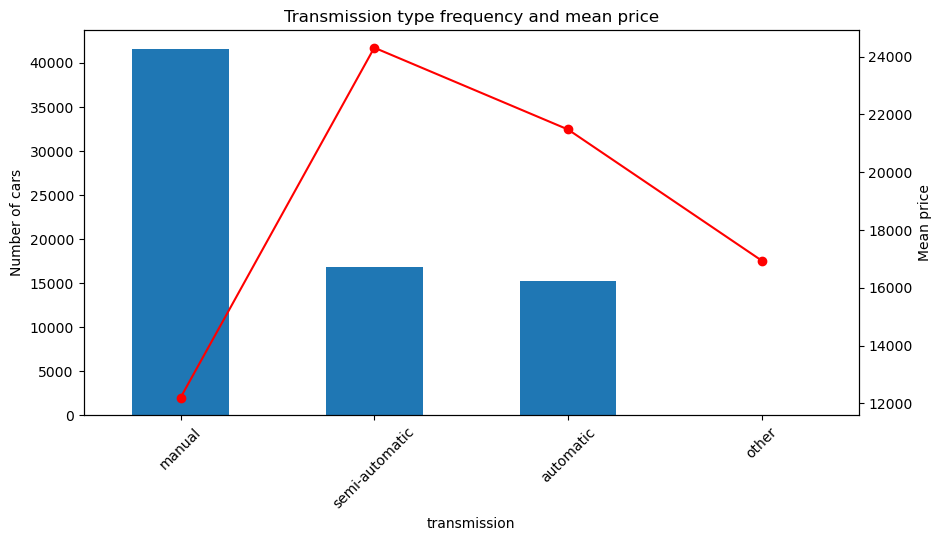

In [48]:
ax = transmission_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(transmission_stats.index, transmission_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Transmission type frequency and mean price")
ax.tick_params(axis='x', rotation=45)

We see considerable differences in price for the multiple transmission types, which means transmission might be a good predictor of price.
*  manual cars are the most common but the cheapest ones;
* semi-automatic and automatic cars are equally famous, but semi-automatic cars are significantly more expensive.
* other, only includes 5 cars, is clearly representing a rare segment of cars (can be considered noise even).

There's no clear relationship between price and frequency for the different types of transmission and few categories, therefore a nice option for encoding is One Hot Encoding.

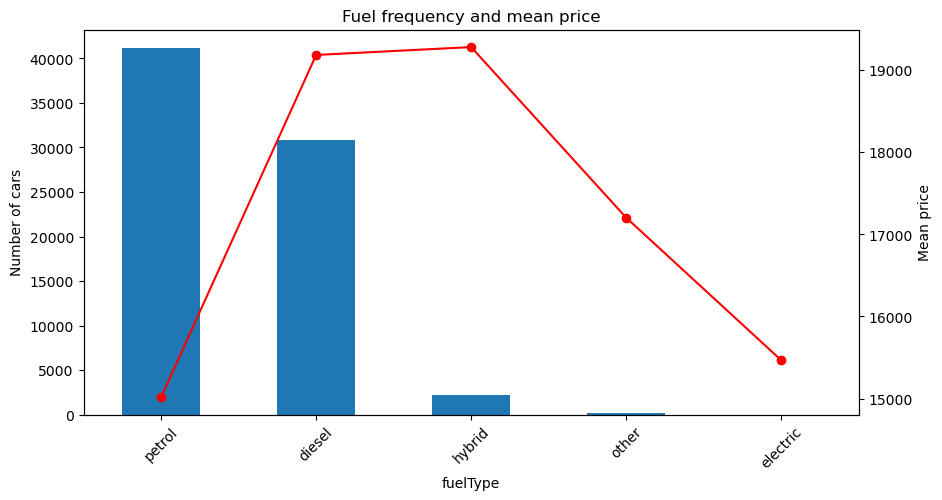

In [49]:
ax = fuel_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(fuel_stats.index, fuel_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Fuel frequency and mean price")
ax.tick_params(axis='x', rotation=45)

There's again differing average prices for each fuel type, therefore fuel is an important variable to consider.
*  petrol is the most common category but represents the cheapest cars;
* diesel and hybrid are the fuel types of the most expensive cars;
* there's only 4 eletric cares in our data;

This variable has low cardinality (few categories) therefore we may opt for One Hot encoding once again.

### 2.2.2 Multidimensional exploration (bivariate)

Using JointGrids with the scatter of price vs independent feature and marginal histograms with the purpose of checking monotonic trends, linearity, and outliers.

We are looking to identify clear upward/downward trends, that would suggests positive/negative association with price.

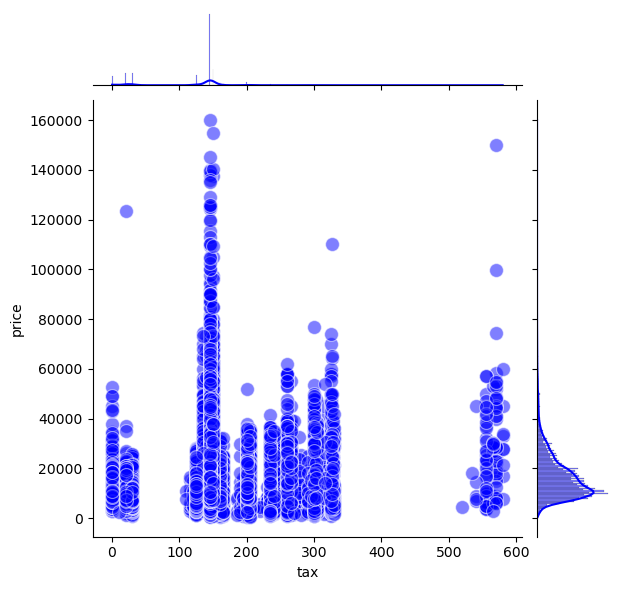

In [50]:
# Bivariate exploration: price ~ tax
exp_prictax = sns.JointGrid(data=train, x="tax", y="price")
exp_prictax.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_prictax.plot_marginals(sns.histplot, kde=True, color='blue')

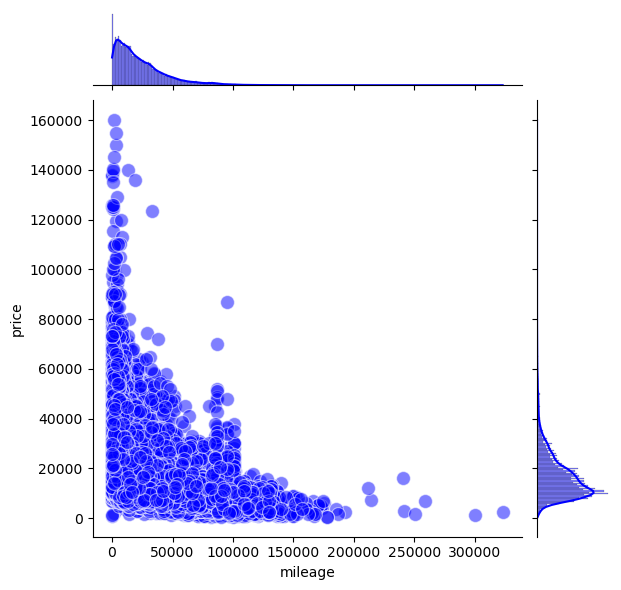

In [51]:
# Bivariate exploration: price ~ mileage
exp_pricmil = sns.JointGrid(data=train, x="mileage", y="price")
exp_pricmil.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricmil.plot_marginals(sns.histplot, kde=True, color='blue')

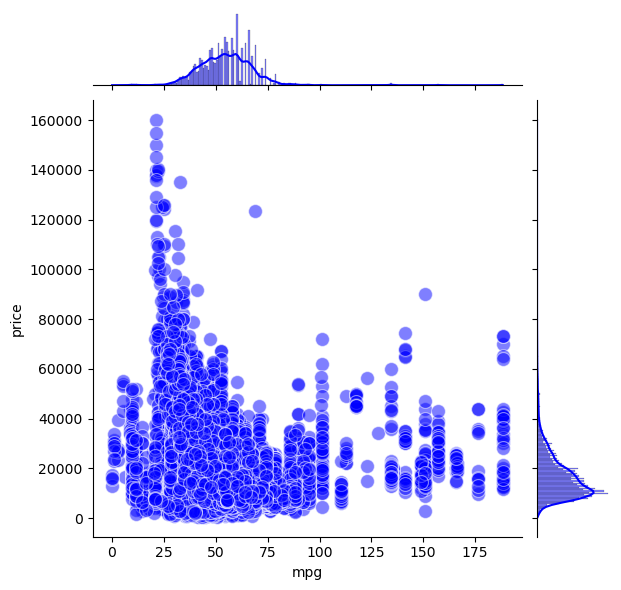

In [52]:
# Bivariate exploration: price ~ mpg
exp_pricmpg = sns.JointGrid(data=train, x="mpg", y="price")
exp_pricmpg.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricmpg.plot_marginals(sns.histplot, kde=True, color='blue')

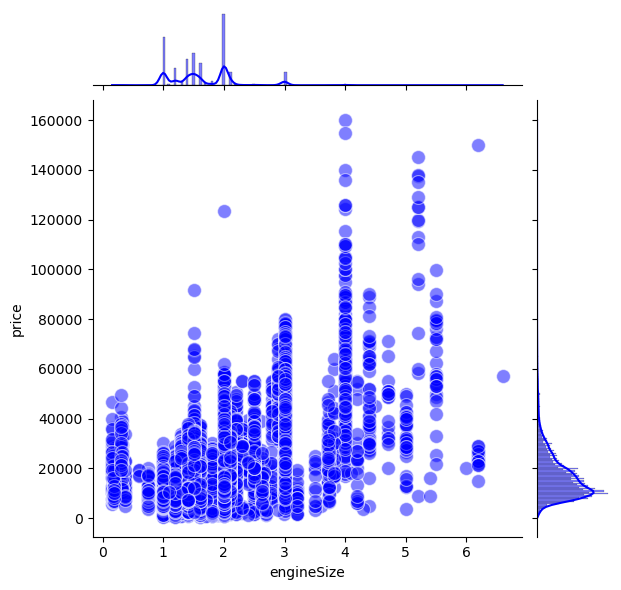

In [53]:
# Bivariate exploration: price ~ engineSize
exp_pricengs = sns.JointGrid(data=train, x="engineSize", y="price")
exp_pricengs.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricengs.plot_marginals(sns.histplot, kde=True, color='blue')

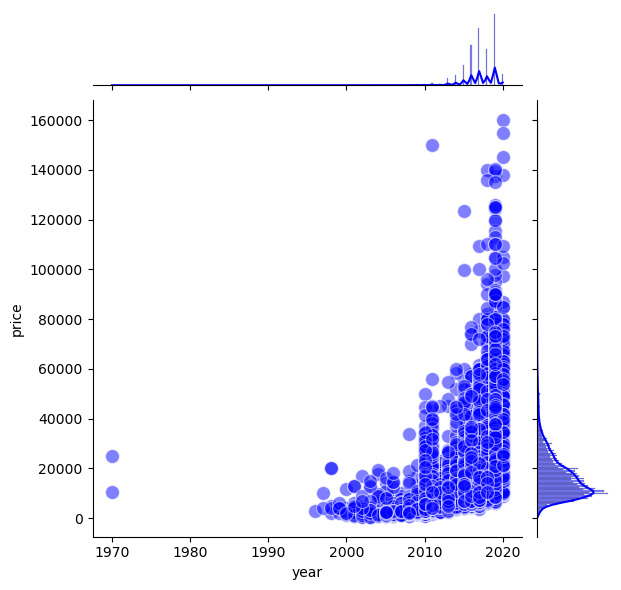

In [54]:
# Bivariate exploration: price ~ year
exp_pricye = sns.JointGrid(data=train, x="year", y="price")
exp_pricye.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricye.plot_marginals(sns.histplot, kde=True,color='blue')

* **mileage**: we observe downward trend (more miles, lower price).

* **tax**: this scatter plot against price showcases a discrete pattern instead of continuous cloud of point, suggesting the exixtance of categories of taxes paid probably due to differing types of engines and fuel emissions. For example, it is to expect that the group of cars with zero tax corresponds to electric cars. We might consider, in feature engineering satges, to create a binned version of this variable, accounting for different tax groups.

* **engineSize**: there's not a clear relationship between the size of the engine and price, we simply can note that the highest prices are, in the majority of cases, associated with larger engines.

* **mpg**: higher prices are correlated with lower values of miles per gallon. We may consider using the inverse of this variable to capture the consumption of fuel per mile. Is this sense, cars with higher consumption per mile are more expensive, according to this visualization.

* **year**: we observe upward trend (newer cars cost more).

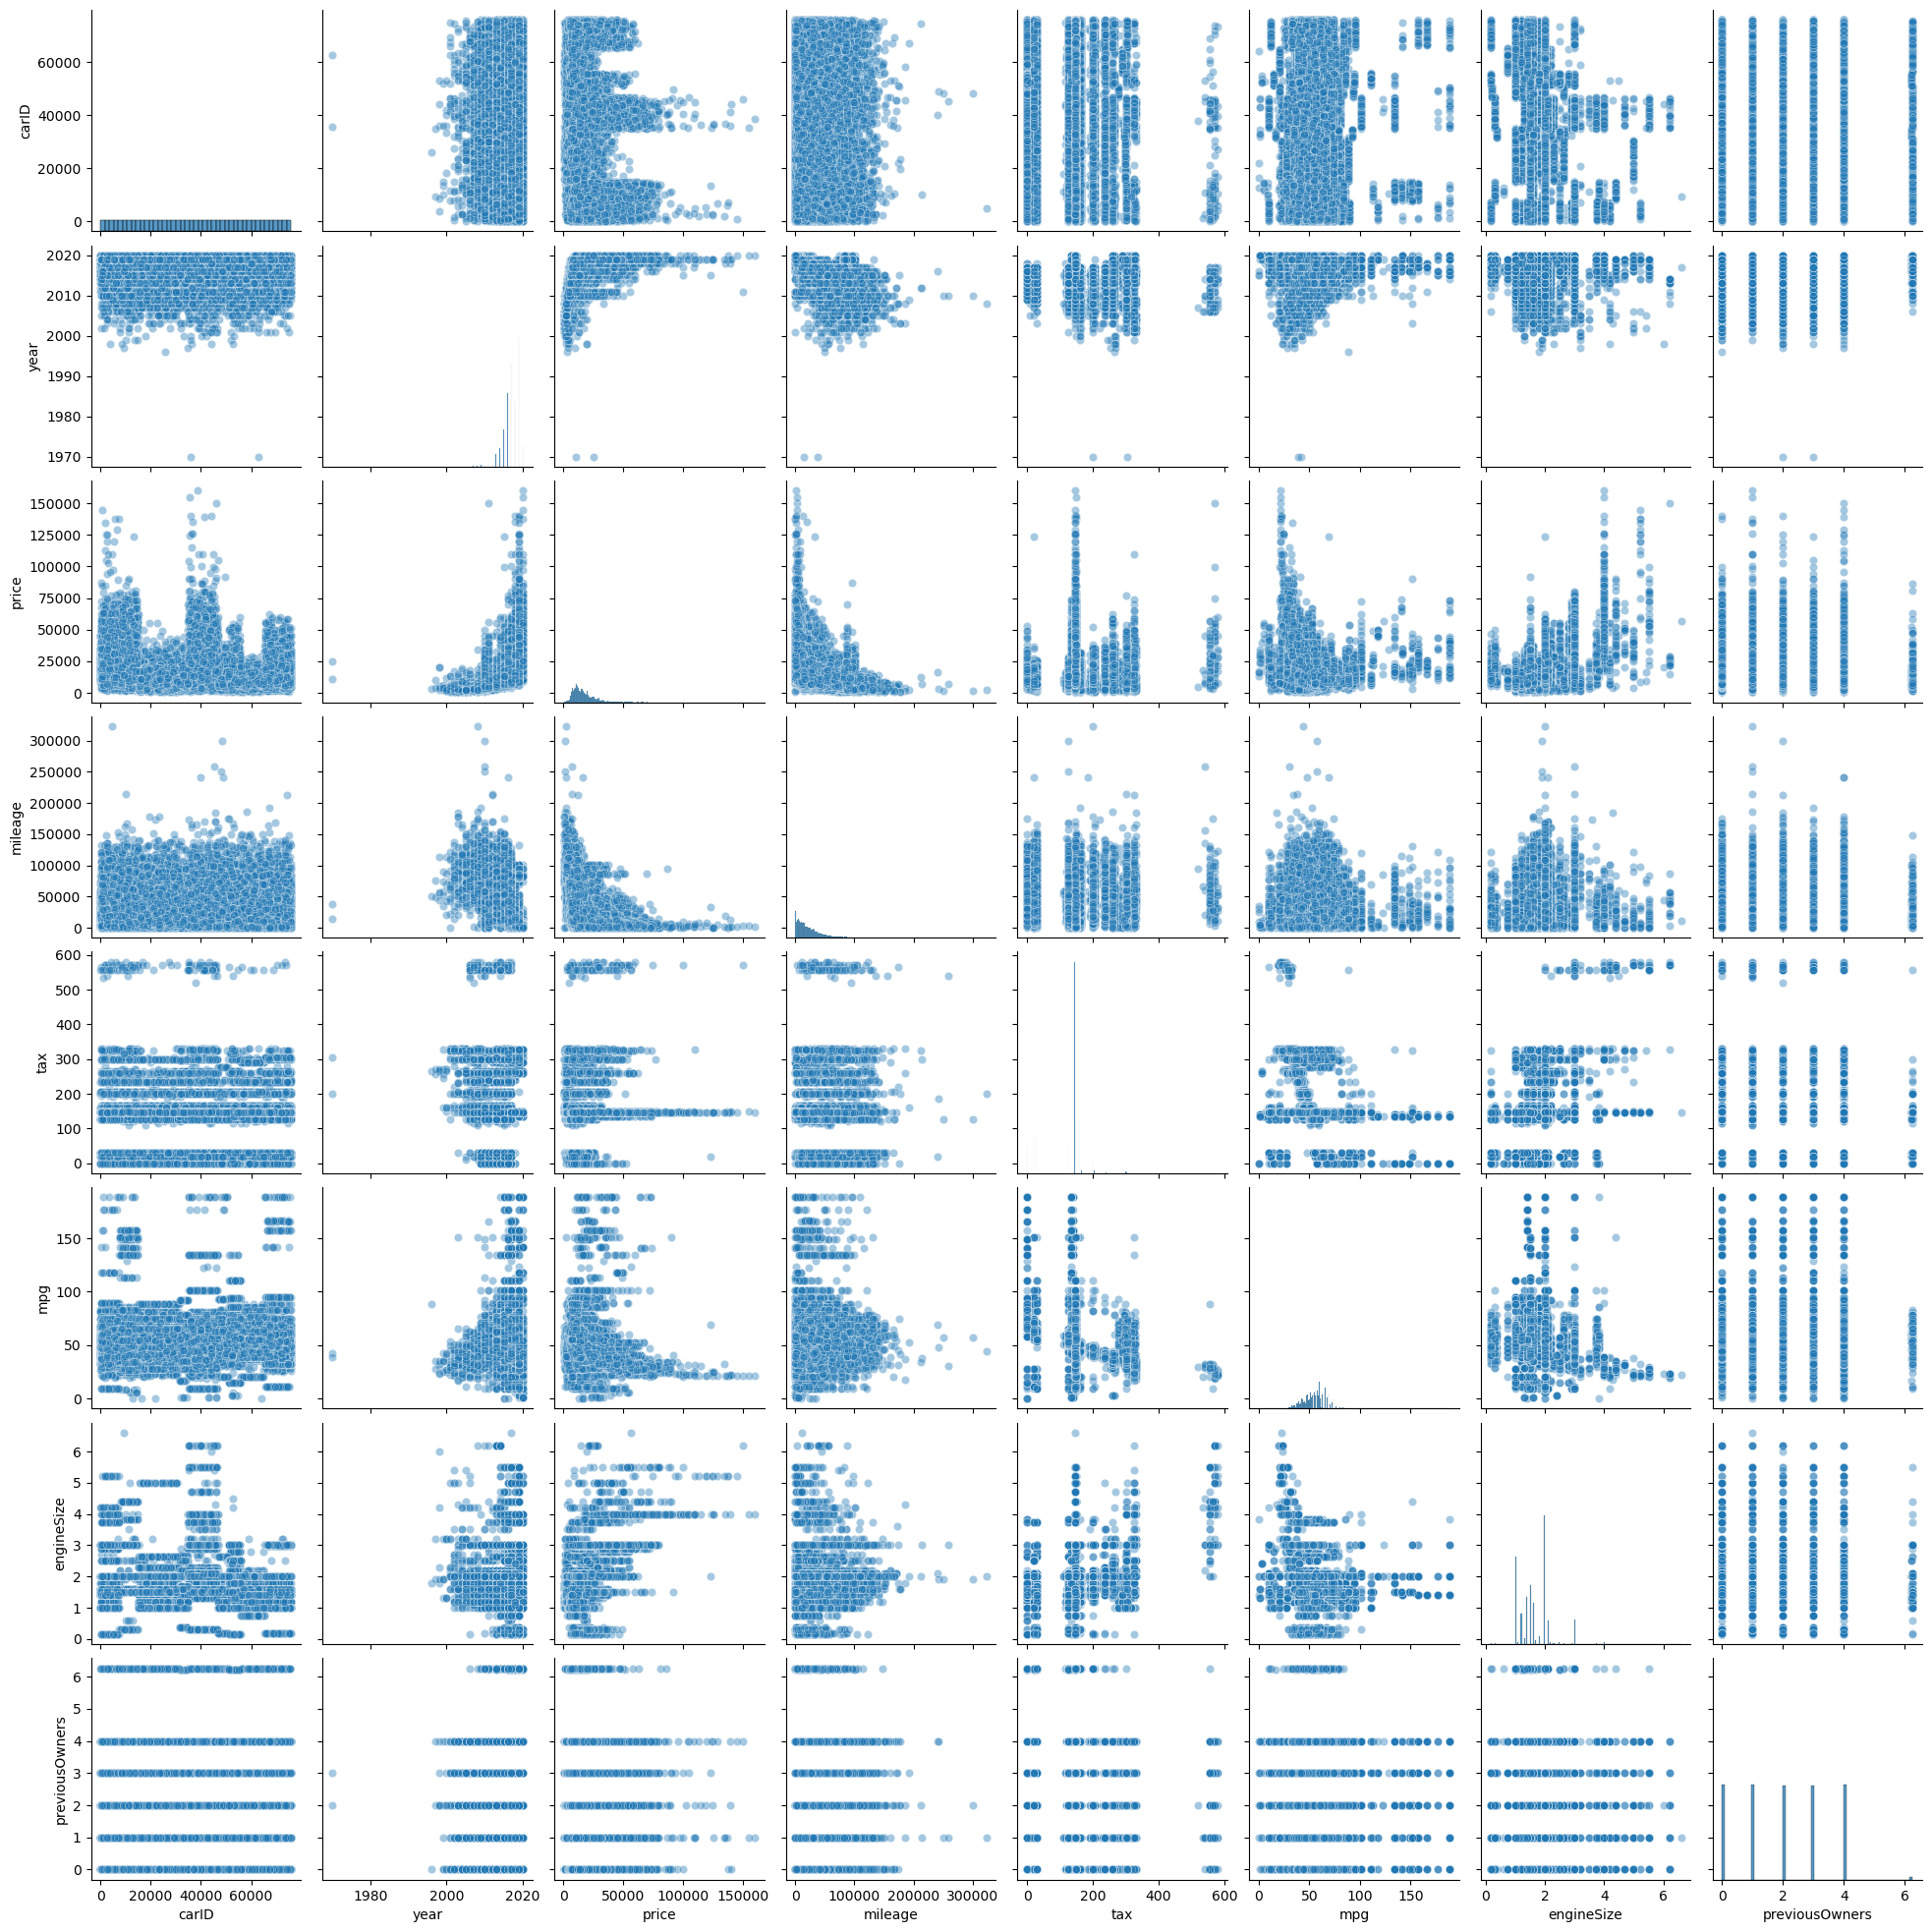

In [55]:
sns.pairplot(train,plot_kws={'alpha':0.4})

The pairplot doesn't reveal any clear relationship between variables.

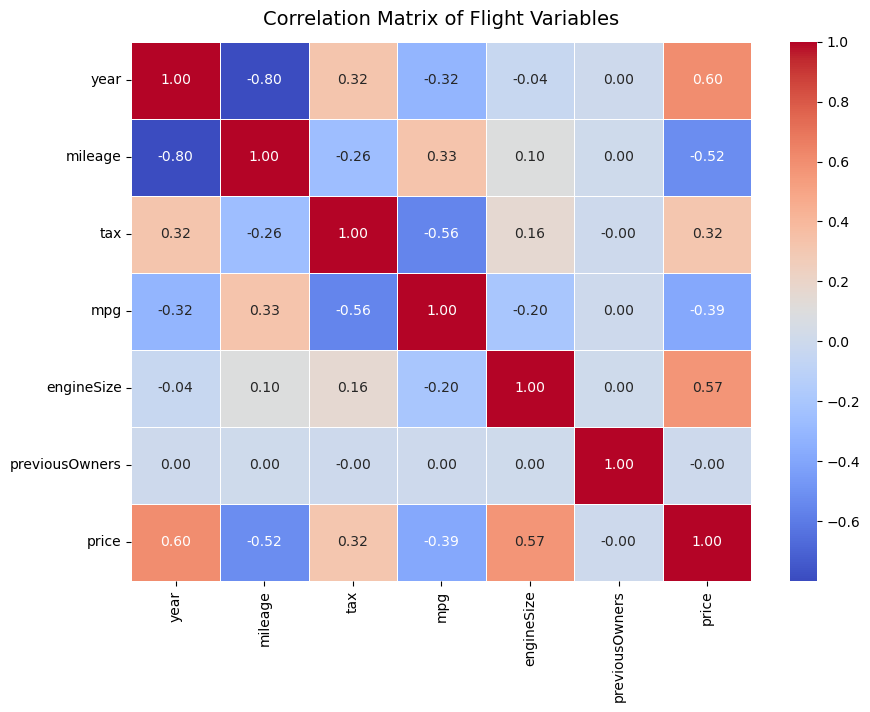

In [56]:
num_cols=['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'price']

# Calculate correlation matrix
corr_matrix = train[num_cols].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Matrix of Flight Variables", fontsize=14, pad=12)
plt.show()

The highest correlations exhibited involve price, mileage and year, meaning that year and mileage will be good predictors of price. On the other hand, paint quality and previous onwers display 0 correlation with the target, probably having very low predictive power.

It is important to note that this visualization it is only suggestive, and we must not take any action based on it, since it uses both train and validation data to compute the correlations. Feature selection  will be performed inside in the k-fold implementation.

In mpg we see that this transformation is not necessary, as the original distribution is already somewhat centered.

Function to apply logs in these variables. This step will be tested when implementing the models. The goal is to test th performance with and without this step.

In [57]:
def add_logs(df):

    df = df.copy()
    for col in ["mileage","tax"]:
        if col in df:
            df[col] = np.log1p(df[col].clip(lower=0))  # safe with zeros
    return df

Applying the logs to 2 the above mentioned variables, after visualizing the original data.

In [58]:
train = add_logs(train)
test = add_logs(test)

 We decided to split the target (price) into 10 deciles (0 = 10% cheapest … 9 = 10% most expensive).

 For each decile we computed the median of each variable and
   normalized per variable using min–max to a 0–1 scale.
With normalization, the test does not compare absolute levels across variables, but compares relative trends.



Text(0.5, 1.0, 'Price decile profiles')

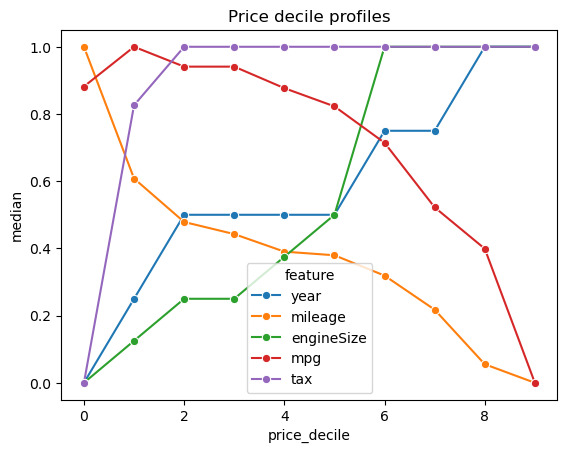

In [59]:
# Price decile profiles
train_data["price_decile"] = pd.qcut(train_data["price"], 10, labels=False)
agg = train_data.groupby("price_decile").agg({
    "year":"median", "mileage":"median", "engineSize":"median", "mpg":"median", "tax":"median",
}).reset_index().melt("price_decile", var_name="feature", value_name="median")


# 0–1 normalization by feature
agg["median"] = agg.groupby("feature")["median"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min()) # min max scaler
)

sns.lineplot(data=agg, x="price_decile", y="median", hue="feature", marker="o")
plt.title("Price decile profiles")



 - mileage decreases in higher deciles (more expensive cars tend to have fewer miles.)
 - year increases in higher deciles ( more expensive cars are more recent.)
 - engineSize increases in top deciles (larger engines in premium segments.)
 - mpg decreases as price increases (efficiency vs. performance trade-off.)
 - tax tends to increase with price (discrete bands linked to emissions/engine size).

<a id="3"></a>

# **3. Feature Engineering**

We decided on creating 4 new variables:
* `car_age`: how old the car is based on year column.

* `mileage_per_year`: a proxy for how used the car is, combining year (how old) and mileage (how worked out is)

* `is_high_end`: a flag to distinguish higher hand brands. (boolean)

* `engine_per_litre_efficiency`: efficiency per motor capacity, a ratio between miles per gallon and engine size.

In [60]:
# some random examples of higher hand brands that might exist on the dataset
LUXURY = {"Audi","BMW","Mercedes","Jaguar","Porsche","Lexus","Volvo","Land Rover"}

def add_features(df):
    df = df.copy()
    # 1) car_age
    if "year" in df:
        df["car_age"] = 2020 - df["year"]

    # 2) mileage_per_year (careful with div/0 e NaN)
    if {"mileage","year"}.issubset(df.columns):
        age = (2020 - df["year"]).replace(0, np.nan)
        df["mileage_per_year"] = (df["mileage"] / age).replace([np.inf, -np.inf], np.nan)

    # 3) is_high_end (NaN -> 0)
    if "Brand" in df:
        df["is_high_end"] = df["Brand"].isin(LUXURY).astype(int).fillna(0)

    # 4) engine_per_litre_efficiency (protect denom=0)
    if {"mpg","engineSize"}.issubset(df.columns):
        denom = df["engineSize"].replace(0, np.nan)
        df["engine_per_litre_efficiency"] = (df["mpg"] / denom).replace([np.inf, -np.inf], np.nan)

    return df

Before implementing the split, we can apply the logs to the aforementioned variables, as this is a deterministic transformation. We will also test some models without this transformation to determine which one better performs.

In [61]:
train = add_features(train)
test = add_features(test)

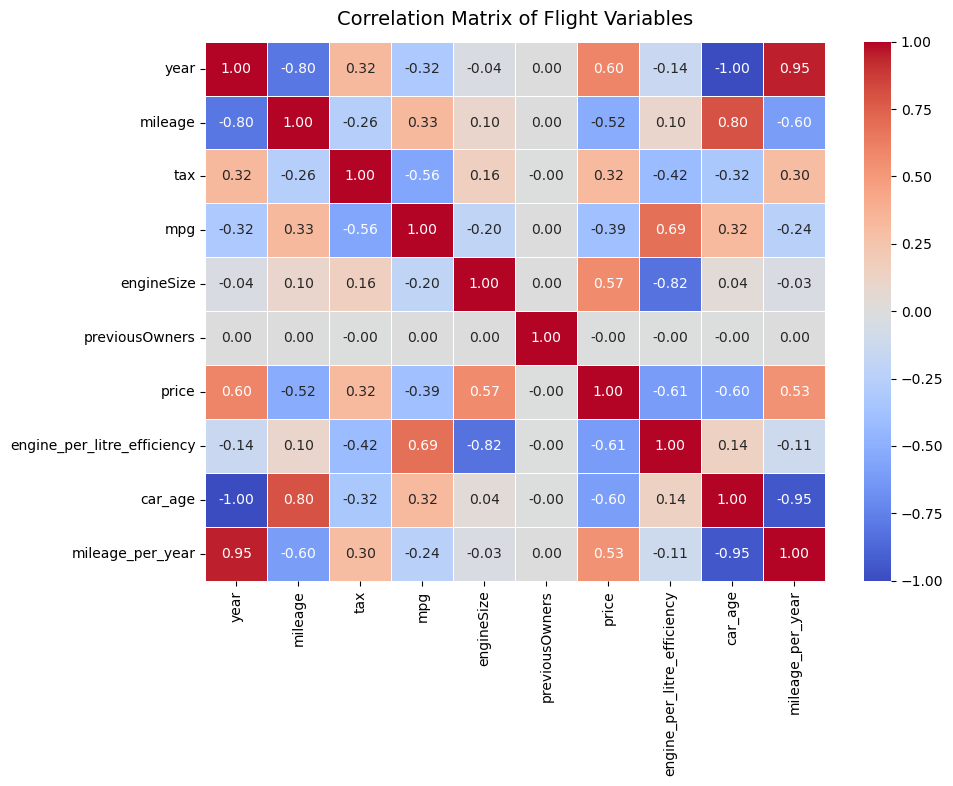

In [62]:
num_cols=['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'price',
          'engine_per_litre_efficiency', 'car_age', 'mileage_per_year']

# Calculate correlation matrix
corr_matrix = train[num_cols].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Matrix of Flight Variables", fontsize=14, pad=12)
plt.show()

Analysing the correlations of the engineered variables and price:
* `car_age` and `year`, as expected are perfectly correlated and are equally correlated with the target. Therefore we should maintain just one (the new, car_age) and delete `year`.
* `engine_per_litre_efficiency`, `car_age`, `mileage_per_year` all showcase correlations above 0.5 (or bellow -0.5) therefore all seem to be meaningful to predict price.

In [63]:
train = train.drop(columns=['year'])
test = test.drop(columns=['year'])

Additionally, the categorical features have to be encoded. The previous analysis, supported by visualizations led us to conclude that:
* frequency encoding for `Brand` and `model` is a good solution, as these features have a considerable number of categories.
* One hot encoding for `fuelType` and `transmission`, since these have few categories.

<a id="3"></a>

# **4. Split using K-fold Cross Validation**

**Regression problem:**
the target, price, is a continuos numeric variable. The present section applies preprocesing and makes predictions to obtain price (predicted values), and compare them to the real values.

 We will start by runing a plenthora of models, including algorithms discussed in the course (linear regressions, KNN, DT, Random Forest and MLP) and other models that seemed suitable for the problem (other ensembles).

**Model Assessment strategy:**
 We evaluated models through 3-fold cross validation, reporting MAE, RMSE, adjusted R2 and R2.

 We will be focusing primarily on** Mean Absolute Error**,  since it is directly interpretable as average absolute pricing error in £ per car and is robust to occasional extreme prices (does not penlize larger errors).

 As secondary strategy, we analyse R2, to understand how much the variability of price is explain by our model, and adjusted R2 when testing solutions using differing number of features.

Separating the taget from the independent features, and dropping the `carID` to prevent it from being used in the model.

In [64]:
TARGET = 'price'
X_train_val = train.drop(columns=[TARGET, 'carID'])
y_train_val = train[TARGET]

This first function trains the model on training data, that will be later used on each fold. It performs simple preprocessing (with only training).

The second function, evaluate model, works in such way that applies all the preprocessing steps on the validation/test data, using the fitted values from the previous function, that worked with the training data. Therefore, it applies the same preprocesisng steps as the `run_model`. Additionally, it performs the predictions on the validation/test and returns the metrics to evaluate the model quality.

Finally, `avg_scores` merges the work of the two previous functions performing the split, using k-fold (with k=5) and applying all the preprocessing steps through `run_model` and `evaluate_model`. After runing the functions for the k folds, it averages the scores and simultaneously creates a "selection bag" to showcase the relative frequency of each selected variable, for the 5 folds.

<a id="3"></a>

# **5. Model Benchmarking**

## 5.1. Common baseline pipeline

For the initial testing of models, we decided on a common baseline pipeline, using the same preprocessing for all models to compare their results accuratly.
* **One Hot encoding** for `transmission` and `fuelType`, and **frequency encoding** for `Brand` and `model`.
* **scaler**: use the robust scaler for all models
* **selector**: selectkbest (filter method) with k=15, for all models.


## 5.2. Benchmark (at least 5 models from class)

Models to test:
* **linear regressions**: ridge and huber
* **KNN** with 10 neighboors (ball tree to improve the efficiency and runing time), and weights associated to distance.
* **Decision tree**: with prepruning (a simple DT almost always overfits)
* **Random forest**, with also some pruning applied.
* **Gradient Boost Regressor** and **Hist gradient boost regressor**: with a defined max depht (4), and learning rate of 0.05.
* **MLP** with 2 hidden layers (15 neurons in the first one and 10 on the second), 500 iterations, learning rate of 0.01 and solver adam.

In [65]:
# instance of KFold with 3 folds
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [66]:
models_to_try = [
        (
        "Ridge_alpha0.5",
        Ridge(alpha=0.5),
        RobustScaler(),
        SelectKBest(score_func=mutual_info_regression, k=15)
    ),
    (
        "Huber_eps1.35_alpha1e-4",
        HuberRegressor(
            epsilon=1.35,
            alpha=0.0001,
            max_iter=1000
        ),
        RobustScaler(),
        SelectKBest(score_func=mutual_info_regression, k=15)
    ),
    (
        "KNN_k10_distance",
        KNeighborsRegressor(
            n_neighbors=10,
            algorithm= 'ball_tree',
            weights='distance',
            p=2              # Euclidian Distance
        ),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),
    (
        "DecisionTree_reg",
        DecisionTreeRegressor(
            max_depth=15,        # intial preprunning strategy, as simple DTs almost always overfit
            min_samples_split=40,
            min_samples_leaf=20,
            random_state=42
        ),
        RobustScaler(),
        SelectKBest(score_func=mutual_info_regression, k=15)
    ),

    (
        "RandomForest",
        RandomForestRegressor(
            n_estimators=300,
            max_depth=15,       # deixa crescer, mas podes limitar mais tarde
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
        ),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),
    (
        "GBR",
        GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_depth=8,
        ),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),
    (
        "HistGBR",
        HistGradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_iter=300,
            max_depth=8,
        ),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),
    (
        "MLP",
        MLPRegressor(
          max_iter=500,
          verbose=False,
          solver='adam',
          activation='relu',
          learning_rate_init=0.01,
          batch_size=256,
          hidden_layer_sizes=(15, 10),
          random_state=42),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),
]

results = []

for name, model, scaler, selector in models_to_try:
    print(f"\n\n===== {name} =====")

    summary, _ = avg_scores(
        kf, X_train_val, y_train_val,
        model=model,
        scaler=scaler,
        fill_method='median',
        selector=selector,
        fe_freq_cols=('Brand','model'),
        ohe_cols=('fuelType','transmission')
    )

    mae_train = summary.loc["MAE", "Train"]
    mae_val = summary.loc["MAE", "Validation"]
    results.append({
        "model": name,
        "mae_train": mae_train,
        "mae_val": mae_val
    })


results_df = pd.DataFrame(results).sort_values("mae_val")
print("\n\n=== Summary of MAE ===")
print(results_df)



===== Ridge_alpha0.5 =====
Nº features after preprocessing: 20
Nº features after feature selection: 15

=== Metrics (Mean K-Fold) ===
               Train    Validation
Adj_R2  7.243000e-01  7.237000e-01
MAE     3.339678e+03  3.341081e+03
MSE     2.613658e+07  2.618116e+07
R2      7.243000e-01  7.239000e-01
RMSE    5.112200e+03  5.115982e+03

=== Feature Selection frequency (proportion of folds) ===
mileage                        1.0
tax                            1.0
mpg                            1.0
engineSize                     1.0
car_age                        1.0
mileage_per_year               1.0
engine_per_litre_efficiency    1.0
Brand_freq                     1.0
model_freq                     1.0
fuelType_diesel                1.0
fuelType_hybrid                1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_semi-automatic    1.0
dtype: float64


===== Huber_eps1.35_alpha1e-4 =====
Nº features after

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 15

=== Metrics (Mean K-Fold) ===
               Train    Validation
Adj_R2  8.416000e-01  8.357000e-01
MAE     2.449688e+03  2.471133e+03
MSE     1.501821e+07  1.557277e+07
R2      8.416000e-01  8.358000e-01
RMSE    3.874360e+03  3.945124e+03

=== Feature Selection frequency (proportion of folds) ===
mileage                        1.0
tax                            1.0
mpg                            1.0
engineSize                     1.0
car_age                        1.0
mileage_per_year               1.0
engine_per_litre_efficiency    1.0
Brand_freq                     1.0
model_freq                     1.0
fuelType_diesel                1.0
fuelType_hybrid                1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_semi-automatic    1.0
dtype: float64


=== Summary of MAE ===
                     model    mae_train      mae_val
6     

| **Model**      | **MAE train** | **MAE val** |  **MAE val - MAE train** | **R2 val** | **Notes** |
|--------------------|--------------|--------------|-----------------|----------------------------|-----------------|
| HistGBR    |    1513 | 1599 | 86 | 0.93 |Best score, and almost doesn't overfit.
| GBR    |    1425 | 1613 | 188 | 0.927| Good score but with some overfit.
| Random Forest    |    1666 | 1817 | 151 | 0.89|Good score but with some overfit.
KNN (k=10) | 20 | 1842 | 1822 | 0.883 | Brutal overfit
Decision Tree | 1741 | 1952 | 211 | 0.874 | Good score but with some overfit, even with prepruning
MLP | 2450 | 2471 | 21 | 0.836 | Not the best score, might need more tunning.
Huber | 3281 | 3292 | 1 | 0.718 | Underfit
Ridge | 3340 | 3241 | 1 | 0.724 | Underfit

In [67]:
# === Modelo A: Gradient Boosting + RFE(Ridge) ===
gbr_rfe = GradientBoostingRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)

selector_rfe = RFE(
    estimator=Ridge(alpha=5.0),
    n_features_to_select=15,
    step=0.2
)

summary_gbr_rfe, _ = avg_scores(
    kf, X_train_val, y_train_val,
    model=gbr_rfe,
    scaler=RobustScaler(),
    fill_method='median',
    selector=selector_rfe,
    fe_freq_cols=('Brand','model'),
    ohe_cols=('fuelType','transmission')
)

mae_gbr_rfe = summary_gbr_rfe.loc["MAE", "Validation"]
print("\nMAE validation - GBR + RFE(Ridge):", mae_gbr_rfe)


# === Modelo B: Gradient Boosting without feature selection ===
gbr_base = GradientBoostingRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)

summary_gbr_base, _ = avg_scores(
    kf, X_train_val, y_train_val,
    model=gbr_base,
    scaler=RobustScaler(),
    fill_method='median',
    selector=None,
    fe_freq_cols=('Brand','model'),
    ohe_cols=('fuelType','transmission')
)

mae_gbr_base = summary_gbr_base.loc["MAE", "Validation"]
print("\nMAE Validation - GBR base (without FS):", mae_gbr_base)


# === Modelo C: Gradient Boosting + SelectKBest(mutual_info_regression) ===
selector_mi = SelectKBest(
    score_func=mutual_info_regression,
    k=15
)

gbr_mi = GradientBoostingRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3
)

summary_gbr_mi, _ = avg_scores(
    kf, X_train_val, y_train_val,
    model=gbr_mi,
    scaler=RobustScaler(),
    fill_method='median',
    selector=selector_mi,
    fe_freq_cols=('Brand','model'),
    ohe_cols=('fuelType','transmission')
)

mae_gbr_mi = summary_gbr_mi.loc["MAE", "Validation"]
print("\nMAE Validation - GBR + SelectKBest(MI):", mae_gbr_mi)


print("GBR + RFE(Ridge):        ", mae_gbr_rfe)
print("GBR without feature selection:", mae_gbr_base)
print("GBR + SelectKBest(MI):   ", mae_gbr_mi)


Nº features after preprocessing: 20
Nº features after feature selection: 15

=== Metrics (Mean K-Fold) ===
               Train    Validation
Adj_R2  8.850000e-01  8.763000e-01
MAE     2.175425e+03  2.208005e+03
MSE     1.089926e+07  1.172171e+07
R2      8.851000e-01  8.764000e-01
RMSE    3.301155e+03  3.422725e+03

=== Feature Selection frequency (proportion of folds) ===
mileage                        1.00
mpg                            1.00
engineSize                     1.00
car_age                        1.00
mileage_per_year               1.00
engine_per_litre_efficiency    1.00
Brand_freq                     1.00
fuelType_electric              1.00
transmission_automatic         1.00
fuelType_hybrid                1.00
fuelType_other                 1.00
fuelType_petrol                1.00
transmission_semi-automatic    1.00
transmission_manual            1.00
fuelType_diesel                0.67
transmission_other             0.33
dtype: float64

MAE validation - GBR + RFE(Ridge

HistGradientBoostingRegressor com max depth 4 que ate e um valor razoavel pelo que o chat disse

In [68]:
models_to_try1 = [
    (
        "RandomForest_modified",
        RandomForestRegressor(
            n_estimators=300,
            max_depth=18,       # allows more growth than previous Random Forest
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
        ),
        RobustScaler(),
        SelectKBest(score_func= mutual_info_regression, k=15)
    ),

]

results = []

for name, model, scaler, selector in models_to_try1:
    print(f"\n\n===== {name} =====")

    summary, _ = avg_scores(
        kf, X_train_val, y_train_val,
        model=model,
        scaler=scaler,
        fill_method='median',
        selector=selector,
        fe_freq_cols=('Brand','model'),
        ohe_cols=('fuelType','transmission')
    )

    mae_val = summary.loc["MAE", "Validation"]
    results.append({
        "model": name,
        "mae_val": mae_val
    })


results_df = pd.DataFrame(results).sort_values("mae_val")
print(results_df)




===== RandomForest_modified =====
Nº features after preprocessing: 20
Nº features after feature selection: 15

=== Metrics (Mean K-Fold) ===
               Train    Validation
Adj_R2  9.078000e-01  8.900000e-01
MAE     1.650302e+03  1.804643e+03
MSE     8.739881e+06  1.044087e+07
R2      9.078000e-01  8.900000e-01
RMSE    2.955334e+03  3.226852e+03

=== Feature Selection frequency (proportion of folds) ===
mileage                        1.0
tax                            1.0
mpg                            1.0
engineSize                     1.0
car_age                        1.0
mileage_per_year               1.0
engine_per_litre_efficiency    1.0
Brand_freq                     1.0
model_freq                     1.0
fuelType_diesel                1.0
fuelType_hybrid                1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_semi-automatic    1.0
dtype: float64
                   model      mae_val
0  RandomF

<a id="3"></a>

# **6. Model Optimization**

## 6.1. Feature selection strategy

## 6.2. Random search

<a id="3"></a>

# **7. Final Model & Kaggle submission**

To export a csv for the kaggle submission:

In [1]:
mdl, sc, fills, sel, cat_modes, freq_maps, dummies, feat_names, _ = run_model(
    X_train_val, y_train_val,
    model=RandomForestRegressor(
            n_estimators=300,
            max_depth=18,
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
        ),
    fill_method='median',
    selector=SelectKBest(score_func= mutual_info_regression, k=15),
    scaler= RobustScaler(),
    fe_freq_cols=('Brand','model'),
    ohe_cols=('fuelType','transmission')
)

# ids & X_test
test_ids = test['carID'].copy().values
X_test   = test.drop(columns=['carID'], errors='ignore')


y_pred = predict_on_test(
    X_test, mdl,
    scaler=sc, fill_values=fills, selector=sel,
    cat_modes=cat_modes, freq_maps=freq_maps, dummies_cols=dummies,
    feature_names=feat_names,
    fe_freq_cols=('Brand','model'), ohe_cols=('fuelType','transmission')
)

id_col = 'carID'
target_col = 'price'

# sanity checks
y_pred = np.asarray(y_pred).ravel().astype(float)
assert len(y_pred) == len(test_ids), f"len preds {len(y_pred)} != len ids {len(test_ids)}"

# export
sub = pd.DataFrame({id_col: test_ids, target_col: y_pred})
output_path = '../submissions/group66_rf_submission.csv'
sub.to_csv(output_path, index=False)
print("submission saved to:", output_path, "->", sub.shape)

NameError: name 'run_model' is not defined

To export the necessary content for the set up of the interface for predictions.

In [70]:
bundle = {
    "model": mdl,
    "scaler": sc,
    "fill_values": fills,
    "selector": sel,
    "cat_modes": cat_modes,
    "freq_maps": freq_maps,
    "dummies_cols": dummies,
    "feature_names": feat_names,
}

joblib.dump(bundle, "../models/car_price_bundle.joblib")


['../models/car_price_bundle.joblib']